In [1]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

# External tools Used: Arxiv and Wikipedia

In [2]:
!pip install arxiv wikipedia

In [4]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

#initialize the wrapper and query run for arxiv
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

#initialize the wrapper and query run for wiki
wiki_wrapper=WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [5]:
#invoke the wiki tool
wiki_tool.invoke("Who is Tom Cruise?")

'Page: Tom Cruise filmography\nSummary: Tom Cruise is an American actor and producer who made his film debut with a minor role in the 1981 romantic drama Endless Love. Two years later, he made his breakthrough by starring in the romantic comedy Risky Business (1983), which garnered his first nominatio'

In [6]:
#invoke the arvix tool
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

Final Tools

In [22]:
tools=[wiki_tool]
tools

[WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/usr/local/lib/python3.11/dist-packages/wikipedia/__init__.py'>, top_k_results=1, lang='en', load_all_available_meta=False, doc_content_chars_max=300))]

# Start Building ChatBot with Langraph

In [23]:
# Importing libraries for chatbot implementation
from typing import Annotated  # Helps in adding extra type hints for better code understanding
from typing_extensions import TypedDict  # Allows creating structured dictionaries with specific data types

# Importing tools for managing chatbot state
from langgraph.graph import StateGraph,START,END

# Importing a function to manage chat messages
from langgraph.graph.message import add_messages

In [24]:
#initialize the state
class State(TypedDict):
    messages:Annotated[list,add_messages]

#initialize StateGraph
graph_builder=StateGraph(State)
graph_builder

In [25]:
from langgraph.graph import StateGraph, START, END

#lets build the chat bot

In [26]:
graph_builder= StateGraph(State)
graph_builder

# Import The LLM model

In [27]:
#let import all the keys
from google.colab import userdata

groq_api_key=userdata.get("GROQ_API_KEY")
langsmith=userdata.get("LANGSMITH_API_KEY")

In [28]:
#initialize environment variables
import os
os.environ["LANGSMITH_API_KEY"]=langsmith
os.environ["LANGCHAIN_TRACKING_V2"]="true"
os.environ["LANGSMITH_PROJECT"]="HandsOnLangraph"

In [29]:
#import the llm model
from langchain_groq import ChatGroq

In [30]:
#instantiate the model
llm=ChatGroq(model_name="gemma2-9b-it", groq_api_key=groq_api_key)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x78cb47ea3610>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x78cb47ea91d0>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

Give LLM Access to the 2 different tools we have selected

In [31]:
#tools=[arxiv_tool,wiki_tool]

llm_with_tools=llm.bind(tools=tools)

# Make the chat bot

In [32]:
# Define chatbot function
def chatbot(state: State):
    # Invoke LLM with messages from state
    response = llm_with_tools.invoke(state["messages"])

    # Return response wrapped properly in a list
    return {"messages": state["messages"] + [response]}

# Create the flow of execution
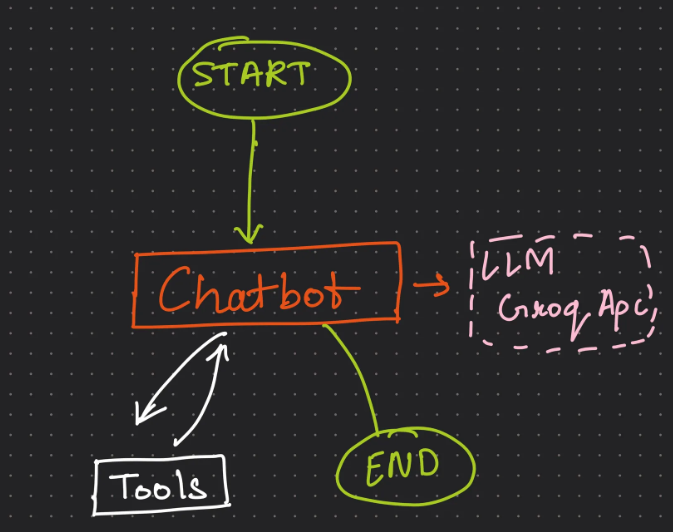

In [33]:
#make the 3 layers
# Check if the node already exists before adding it
if "chatbot" not in graph_builder.nodes:  # Add this line
  graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")


#for the custom or third party tools
from langgraph.prebuilt import ToolNode,tools_condition
tool_node=ToolNode(tools=tools)

# Check if the node already exists before adding it
if "tools" not in graph_builder.nodes:  # Add this line
    graph_builder.add_node("tools",tool_node)

#conditional edge since tools is bidirectional
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

In [34]:
graph=graph_builder.compile()

i got this piece of code from the documenatation https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-1-build-a-basic-chatbot

In [35]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [37]:
user_input="Hi there!, My name is John"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()


================================ Human Message =================================

Hi there!, My name is John


PydanticSerializationError: Unable to serialize unknown type: <class 'module'>